In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve


# Import data

In [83]:
gdpnow = pd.read_csv('gdpnow_hf.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

In [44]:
gdpnow.columns

Index(['GSUSFCI Index_x', 'CESIUSD Index_x', 'value', 'value_CCLACBW027SBOG',
       'value_WTISPLC', 'value_EXPINF1YR', 'value_STLPPM', 'value_M2REAL',
       'value_UNRATE', 'value_PPIACO', 'value_PCUOMFGOMFG',
       'value_PCUATRANSATRANS', 'value_PCUATRADEATRADE',
       'value_PCUAWHLTRAWHLTR', 'value_CSUSHPINSA', 'value_SPCS20RSA',
       'value_WALCL', 'value_SP500', 'value_T5YIFR',
       'value_REAINTRATREARAT10Y', 'value_SAHMREALTIME', 'value_POPTHM',
       'value_CES0500000003', 'value_MORTGAGE30US',
       'Monthly Nominal GDP Index', 'Monthly Real GDP Index', 'ADPWNUSNERSA',
       'WEI', 'USGGBE02 Index', 'USOSFR10 Curncy', 'CL1 Comdty',
       'USOSFR2 Curncy', 'NDX Index ', 'SPX Index ', 'USDJPY Curncy',
       'GSUSFCI Index_y', 'CESIUSD Index_y', 'Advance Estimate From BEA',
       'Business Fixed Investment',
       'Change in inventory investment ($Bil 2009)',
       'Change in net exports ($Bil 2009)',
       'Current change in private inventories ($Bil 2009)', '

## Let's define X and y - Make Sure to Pick your Target 

In [75]:
# Target S&P
Target = 'SPX Index '
Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
       'Days until advance estimate', 'Forecast Error', 'Data releases', 'NDX Index ', 'SPX Index ','value_SP500']

# # Target USDJPY
# Target = 'USDJPY Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USDJPY Curncy']

# # Target 2y Interest Rates
# Target = 'USOSFR2 Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USOSFR2 Curncy', 'USOSFR10 Curncy']

# # Target WTI Oil
# Target = 'CL1 Comdty'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'CL1 Comdty']

# # Target GDP
# Target = 'Final_GDP_Interp'
# Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases']

# How to deal with all the NAs ?

From here on lets try two different datasets as in how to work with the NAs:
1. ffil
2. dropping NAs

In [76]:
len(gdpnow.columns)

73

In [77]:
gdpnow_filled = gdpnow.fillna(method='ffill')
# Two variables are empty quite a lot
gdpnow_dropped = gdpnow.dropna(axis=0, thresh=len(gdpnow.columns)-2)

In [78]:
gdpnow_filled.shape, gdpnow_dropped.shape

((2537, 73), (1496, 73))

# Defining X and y

We now need the X and Y for the three different data sets

In [79]:
# defining X and y for all three data sets (initial, dropped and filled)
X = gdpnow.drop(columns=Drop)
y = gdpnow[Target]

X_filled = gdpnow_filled.drop(columns=Drop)
y_filled = gdpnow_filled[Target]

X_dropped = gdpnow_dropped.drop(columns=Drop)
y_dropped = gdpnow_dropped[Target]

assert(X.shape[0]==y.shape[0])
assert(X_filled.shape[0]==y_filled.shape[0])
assert(X_dropped.shape[0]==y_dropped.shape[0])

In [65]:
# Splitting into test and train sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
    train_test_split(X_filled, y_filled, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = \
    train_test_split(X_dropped, y_dropped, test_size=0.20)


# Pipeline

In [80]:
preproc = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

preproc_selector = Pipeline([
    ('preprocessing', preproc),  # Include the preprocessing steps with PCA
    ('feature_selection', SelectPercentile(
        mutual_info_regression,
        percentile=90 # Keep 90% of all features
    ))
])

# Modeling

In [81]:
#Modeling with initial dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': [0.1],
    'model__max_depth': [16, 20],
}

pipe = Pipeline([
    ('preprocessor', preproc),
    ('model', model)
])

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='r2',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=2,
    #random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  12.5s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  12.5s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=  12.8s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  12.9s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  12.9s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  12.9s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=  13.0s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=  12.9s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   3.0s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   3.2s


In [68]:
random_search.score(X_test, y_test)

0.9980899909580951

In [23]:
#Modeling with filled dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': [0.1],
    'model__max_depth': [16, 20],
}

pipe = Pipeline([
    ('preprocessor', preproc),
    ('model', model)
])

random_search_filled = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_filled.fit(X_filled_train, y_filled_train)

print("Best parameters found: ", random_search_filled.best_params_)
print("Best score found: ", random_search_filled.best_score_)

/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'model__n_estimators': 200, 'model__max_depth': 16, 'model__learning_rate': 0.1}
Best score found:  -17.777515698406994


In [24]:
random_search_filled.score(X_filled_test, y_filled_test)

-16.18066981998955

In [25]:
#Modeling with 'dropped' dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': [0.1],
    'model__max_depth': [16, 20],
}

pipe = Pipeline([
    ('preprocessor', preproc),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_)

/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  35.6s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  35.5s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  34.8s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  35.7s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=  36.3s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=  37.2s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=  37.2s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=  37.2s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   7.4s
[CV] END model__learning_rate=0.1, model

In [26]:
random_search_dropped.score(X_dropped_test, y_dropped_test)

-23.750224300130213

In [30]:
y_dropped_pred = random_search_dropped.predict(X_dropped_test)

In [28]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate evaluation metrics
mae_train = mean_absolute_error(y_dropped_train, random_search_dropped.predict(X_dropped_train))
mae_test = mean_absolute_error(y_dropped_test, random_search_dropped.predict(X_dropped_test))
r2_train = r2_score(y_dropped_train, random_search_dropped.predict(X_dropped_train))
r2_test = r2_score(y_dropped_test, random_search_dropped.predict(X_dropped_test))

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MAE: 0.0034358097956794266
Test MAE: 23.750224300130213
Train R^2: 0.999999999968143
Test R^2: 0.9982194058639275


# Finetuning

### Using a feature selector

We have shown that either filling in or dropping gives way more promising results than just imputing

Thus, we will focus on these approaches

In [29]:
#Modeling with filled dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': stats.uniform(0.01 , 0.5),
    'model__max_depth': [16, 20],
     'preprocessor_selector__feature_selection__percentile': [60, 70, 80, 90],
}

pipe = Pipeline([
    ('preprocessor_selector', preproc_selector),
    ('model', model)
])

random_search_filled = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_filled.fit(X_filled_train, y_filled_train)

print("Best parameters found: ", random_search_filled.best_params_)
print("Best score found: ", random_search_filled.best_score_)

KeyboardInterrupt: 

In [ ]:
#Modeling with filled dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': stats.uniform(0.01 , 0.5),
    'model__max_depth': stats.randint(12,28),
    'preprocessor_selector__feature_selection__percentile': stats.uniform(10,90),
}

pipe = Pipeline([
    ('preprocessor_selector', preproc_selector),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_)

Best parameters found:  {'model__learning_rate': 0.16239062907901453, 'model__max_depth': 17, 'model__n_estimators': 200, 'preprocessor_selector__feature_selection__percentile': 55.967257231980916}
Best score found:  -0.22561240261880666


In [31]:
random_search_dropped.score(X_dropped_test, y_dropped_test)

-23.750224300130213

In [32]:
y_pred = random_search_dropped.predict(X_dropped_test)

In [33]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [34]:
y_pred.index = y_dropped_test.index
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_plot = pd.concat([gdpnow.loc[X_dropped_test.index]['Days until advance estimate'], y_dropped_test, y_pred], axis=1)
df_plot

,Days until advance estimate,SPX Index,0
Dates,,,
2015-10-09,20.0,2014.89,2054.119873
2019-10-03,27.0,2910.63,2928.247314
2019-03-25,32.0,2798.36,2804.461426
2019-05-24,63.0,2826.06,2821.994385
2018-01-24,2.0,2837.54,2799.642334
...,...,...,...
2022-08-03,85.0,4155.17,4121.733887
2020-06-01,59.0,3055.73,3028.065918
2021-06-01,58.0,4202.04,4190.960449


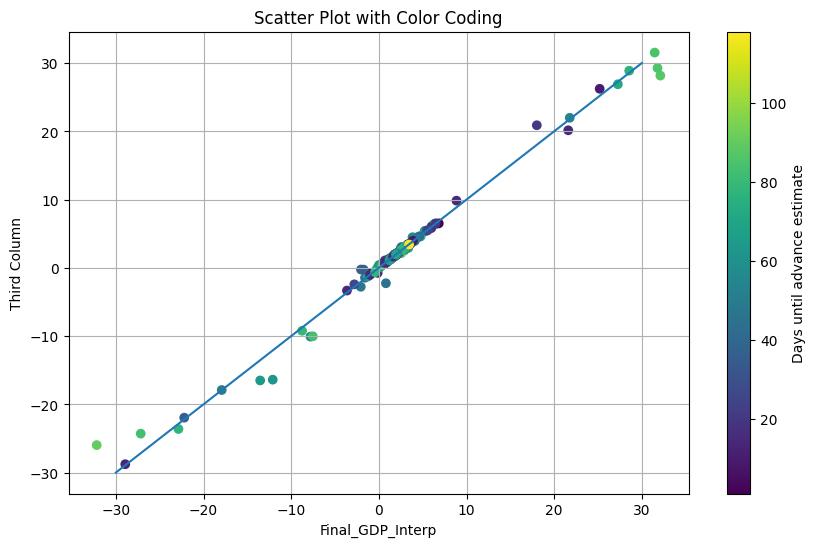

In [ ]:
a=[-30,30]
b=[-30,30]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot['Final_GDP_Interp'], df_plot[0], c=df_plot['Days until advance estimate'], cmap='viridis')
plt.colorbar(scatter, label='Days until advance estimate')
plt.xlabel('Final_GDP_Interp')
plt.ylabel('Third Column')
plt.title('Scatter Plot with Color Coding')
plt.grid(True)
plt.show()

# Comparing scores with GDPNOW

In [35]:
gdpnow_test = gdpnow_dropped['GDP Nowcast']
gdpnow_test = gdpnow_test.interpolate(method='time')
gdp_test = gdpnow_dropped['Final_GDP_Interp']

In [36]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    if type(y_pred) == pd.Series:
        mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    else:
        mins = np.amin(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [37]:
forecast_accuracy(random_search_dropped.predict(X_dropped_test), y_dropped_test)

{'mape': 0.007208642679981252,
 'me': -4.136954638671902,
 'mae': 23.750224300130213,
 'mpe': -0.0008432461626889953,
 'rmse': 36.941795183475456,
 'acf1': -0.0024278086535923886,
 'corr': 0.9991389102383409,
 'minmax': 0.007164236702078219}

In [38]:
forecast_accuracy(gdpnow_test,gdp_test)

/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_84279/1438552970.py:15: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


{'mape': 1.0052173257056338,
 'me': 0.4431112847125225,
 'mae': 2.7196656763835896,
 'mpe': 0.22596797133268812,
 'rmse': 7.243805910567935,
 'acf1': 0.9706041856039092,
 'corr': 0.5693452275251626,
 'minmax': inf}